In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('GUIDE_Test.csv')

C:\Users\deepa\AppData\Local\Temp\ipykernel_14248\3937674481.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('GUIDE_Test.csv')


In [3]:
df.shape

(4147992, 46)

In [4]:
df.isna().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       2307104
IncidentGrade               0
ActionGrouped         4146079
ActionGranular        4146079
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        4106285
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          4116614
FileName                    0
FolderPath

In [5]:
df = df.dropna(thresh=0.4 * len(df), axis=1)

In [6]:
df.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       2307104
IncidentGrade               0
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
FileName                    0
FolderPath                  0
ResourceIdName              0
OSFamily                    0
OSVersion                   0
CountryCod

In [7]:
df['Hour'] = pd.to_datetime(df['Timestamp']).dt.hour
df['DayOfWeek'] = pd.to_datetime(df['Timestamp']).dt.dayofweek
df.drop("Timestamp",axis=1,inplace=True)
missing_datas = df.groupby(df["MitreTechniques"].isnull())['IncidentGrade'].value_counts()
technique_count = df.groupby(["IncidentGrade", "MitreTechniques"]).size().reset_index(name="count")
sorted_technique = technique_count.sort_values(["IncidentGrade","count"],ascending=[True, False])
most_commons = sorted_technique.loc[sorted_technique.groupby("IncidentGrade")["count"].idxmax()]
fill_mapping = {
    "BenignPositive": "T1566.002",
    "FalsePositive": "T1078;T1078.004",
    "TruePositive": "T1078;T1078.004"
}

df["MitreTechniques"] = df["MitreTechniques"].fillna(df["IncidentGrade"].map(fill_mapping))

In [8]:
technique_count
sorted_technique
most_commons

,IncidentGrade,MitreTechniques,count
761,BenignPositive,T1566.002,172062
1038,FalsePositive,T1078;T1078.004,133875
1408,TruePositive,T1078;T1078.004,468729


In [9]:
df.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
DetectorId            0
AlertTitle            0
Category              0
MitreTechniques       0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
Usage                 0
Hour                  0
DayOfWeek             0
dtype: int64

In [10]:
df["MitreTechniques"] = df["MitreTechniques"].map(lambda x: x.split(";")[0])

In [11]:
df.drop_duplicates()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,EntityType,...,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Usage,Hour,DayOfWeek
0,1245540519230,657,11767,87199,524,563,LateralMovement,T1021,BenignPositive,User,...,117668,3586,5,66,242,1445,10630,Private,22,1
1,1400159342154,3,91158,632273,2,2,CommandAndControl,T1566.002,BenignPositive,Machine,...,117668,3586,0,0,242,1445,10630,Public,12,0
2,1279900255923,145,32247,131719,2932,10807,LateralMovement,T1021,BenignPositive,Process,...,22,3586,5,66,242,1445,10630,Public,3,5
3,60129547292,222,15294,917686,0,0,InitialAccess,T1078,FalsePositive,CloudLogonSession,...,117668,3586,5,66,242,1445,10630,Public,12,2
4,515396080539,363,7615,5944,27,18,Discovery,T1087,BenignPositive,User,...,117668,3586,5,66,242,1445,10630,Public,17,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147985,171798692464,42,391,638112,135,7322,Malware,T1566.002,BenignPositive,Machine,...,117668,3586,0,0,242,1445,10630,Public,20,0
4147987,541165881145,262,3017,227156,139,120,InitialAccess,T1566.002,BenignPositive,User,...,117668,3586,5,66,242,1445,10630,Public,3,1
4147988,438086666953,1323,31001,304819,219,196,InitialAccess,T1566.002,BenignPositive,User,...,117668,3586,5,66,242,1445,10630,Private,19,1
4147989,1297080124487,47,3653,7243,57,29,CommandAndControl,T1046,FalsePositive,Ip,...,117668,3586,5,66,242,1445,10630,Public,0,5


In [12]:
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

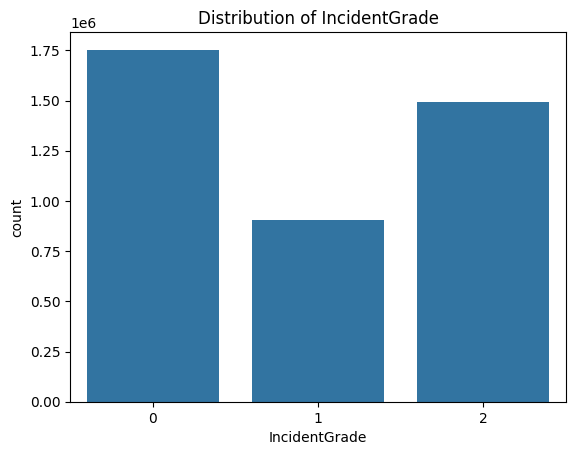

In [13]:
sns.countplot(x=df["IncidentGrade"])
plt.title("Distribution of IncidentGrade")
plt.show()

In [14]:
from sklearn.utils import resample

min_class_size = df["IncidentGrade"].value_counts().min()

df_balanced = pd.concat([
    resample(df[df["IncidentGrade"] == cls], 
             replace=False, 
             n_samples=min_class_size, 
             random_state=42)
    for cls in df["IncidentGrade"].unique()
])
print(df_balanced["IncidentGrade"].value_counts())

IncidentGrade
0    902698
1    902698
2    902698
Name: count, dtype: int64


In [15]:
numeric_columns = df_balanced.select_dtypes(include=['number']).columns
scaler = StandardScaler()
data_scaled =scaler.fit_transform(df_balanced[numeric_columns])
data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_columns)

In [16]:
df_balanced.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'MitreTechniques', 'IncidentGrade', 'EntityType',
       'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid',
       'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName',
       'NetworkMessageId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName',
       'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City', 'Usage',
       'Hour', 'DayOfWeek'],
      dtype='object')

In [17]:
X = df_balanced[['MitreTechniques',
 'OrgId',
 'IncidentId',
 'DetectorId',
 'AlertTitle',
 'AlertId',
 'Category',
 'EntityType',
 'CountryCode',
 'IpAddress',
 'AccountUpn',
 'DeviceName',
 'EvidenceRole',
 'NetworkMessageId',
 'AccountName',
 'DayOfWeek']]

In [18]:
y = df_balanced['IncidentGrade']

In [19]:
X.shape

(2708094, 16)

In [20]:
import joblib
best_model = joblib.load('XGB.joblib')

In [21]:
xgb_pred= best_model.predict(X)

In [22]:
print(classification_report(y,xgb_pred))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81    902698
           1       0.78      0.89      0.83    902698
           2       0.90      0.86      0.88    902698

    accuracy                           0.84   2708094
   macro avg       0.85      0.84      0.84   2708094
weighted avg       0.85      0.84      0.84   2708094



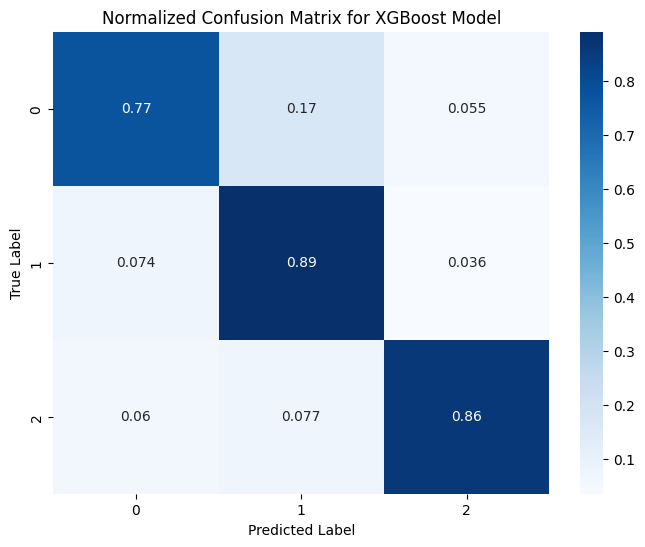

In [28]:
cm = confusion_matrix(y, xgb_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap="Blues")

# Labels and title
plt.xlabel("Predicted Label")plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix for XGBoost Model")
plt.show()
